# <a id='toc1_'></a>[INTRO](#toc0_)

1/ the typical nose of a dog is 100.000 to a million times as sensitive as a human's nose and where as only 5% of a human brain is dedicated to odors, in dogs it is 33% (source wikipedia and internet)
2/ parkinsons disease is an illness that can be treated better when it is detected before symptoms are visible for humans. 
3/ a dog can detect the odor of parkinson before the symptoms are visble. 
4/ a chinese professor started training dogs to detect the parkinsons disease in the odor of the patient's t-shirts in 2020.
5/ the dog learned to lie down when it detects the odor. 

but sometimes the dog has another behavior too. Maybe it is detecting something else? Maybe it just has another behavior. 

The professor filmed the dog sniffing jars with the odor of patients with parkinson's disease and other patients. 
And he wanted to try if computer vision can be used to detect other behavior. 

The code in this notebook is used to prepare a dataset of video snippets for a video classification model. RNN more specifically a Gated Recurrent Unit model. The model is made in the tensorflow and keras family and as they are working very well and are well documented this code in this notebook is primaly based on this. 

The videos show a dog sniffing jars. The dog is trained to detect the odor of Parkinson's disease in the jars. When it detects the odor the dog lies down before the jar.

First we will cut the videos in smaller snippets showing the behavior of the dog when it starts sniffing a jar, until it sniffs the next jar. The cutting of the videos is automated. We used Cvat to annotate images of the dog's nose and of the jar. Then we used Detectron2 to have bounding boxes on 100 videos. The code detects when the bounding box of the nose is touching the bounding box of a jar and registers the timestamp when this happens. This timestamp is later used to cut the videos in shorter snippets. 
The code to make the snippets is in the other jupyter notebook. 

Then we make a balanced dataset with an equal number of negative and positive snippets. 
As there are more negative jars than positive jars this balancing is needed for the video classification model to train well. 

We first analysed the duration of the snippets. The snippets have a variable length from 0.2 seconds to 33 seconds.

The  dataset is split in train and test set (20%). 

The snippets of the train set will then be cut in sequences of 50 frames. The snippets have 30 frames per second. The number of frames depends on the length of the snippet. The longest snippet is 33 seconds and has 990 frames, the shortest is 0.2 seconds and has 6 frames. 
As all the sequences that pass through the model must have the same length, a part of the preprocessing is to add zeros in the numpy array created when converting the frames of a snippet to a numpy array. 

After this the frames are analysed with feature extraction model Inception v3. This feature extraction model is trained on the large dataset of UCF101 of human behavior and will extract interesting features in the frames like moving elements, colors, shapes and will mask features like for example the background. 

Then the sequence of frames and masks are used as input for a GRU model in order to classify the snippet as "dog sniffing a positive jar" or "dog is sniffing a negative jar". In this context positive means a jar containing the odor of a patient having parkinson's Disease, a negative jar containing the odor of a patient that doesn't have the parkinson's disease. The dog is trained to lie down if the parkinson's disease is detected. 

The RNN model will be trained to classify the snippet as negative or positive. 
The goal is to use the classification model to detect other behavior than lying down before the jar, to detect false negatives in the samples. To eventually improve the premature detection of the disease which could significantly help the treatment of it. 

The Gated Recurrent Unit model has 3 bidirectional layers. The input of the first layer is a double input: the sequence of 50 frames of the snippets and their extracted features (called masks). 
The output of the first layer is the input of the second one and the output of the second layer is the input for the third layer. After that follows a Dense layer with dropout to avoid overfitting and the last dense layer with the softmax classification with 2 classes: negative and postive. 
The units of each layers represent the neurons that are connected to each other to pass the sequence of frames through. In the used model the units are 64 - 32 and 16. 
Experiments were done with less layers and more units and more layers with less units and based on the the accuracy and recall results we chose the architecture is mentionned above. 

After the building of the model, the model is trained using a balanced dataset of snippets for negative and positive jars. The Adam optimizer is used to adapt the learning rate and to have a more stable learning curve. Other adaptions are early dropout when the validation loss is not improving. 

Once trained the model will be run on the training set using a threshold to improve the detection of false negatives. Snippets will be classified as positive (even if they are negative) if the model classifies the jar as positive with a confidence of 45% or higher. 

After the training we will run the model on the test set and the validation loss and accuracy is used as metric.

When satisfactory we use the model to predict the class of the test set and compare the results with the true class. This will be used to make the classification report on the test set as we are interested in the recall of the positive class. 

Then we will run the model on the complete dataset and make the classification again. 

We analyse the duration of the snippets again and define the duration of snippet with a 95% probability that the snippet is for a positive jar. 

We make a metric of the correctness of the dog's detection as a benchmark for the results of the video classification model.

We make the final classification report, confusion matrix, ROC/AUC and barplot for the error in the predictions of the error. 

  

**Table of contents**<a id='toc0_'></a>    
- [INTRO](#toc1_)    
- [CONTENT](#toc2_)    
- [LIBRARIES](#toc3_)    
- [FOLDERS](#toc4_)    
- [READ POSITIVE AND NEGATIVE](#toc5_)    
- [COUNT dataset used for training](#toc6_)    
- [IMPORT DATA](#toc7_)    
- [HISTOGRAM](#toc8_)    
- [BOXPLOT DURATION](#toc9_)    
- [SPLIT TRAIN TEST](#toc10_)    
- [FUNCTION LOAD / CROP VIDEO](#toc11_)    
    - [IMAGE SIZE](#toc11_1_1_)    
- [FUNCTION INCEPTION V3 FEATURE EXTRACTION](#toc12_)    
- [GATED RECURRENT UNIT BIDIRECTIONAL LAYERS](#toc13_)    
  - [PARAMETERS GRU](#toc13_1_)    
  - [FUNCTION VIDEO PREP](#toc13_2_)    
  - [SEQUENCE MODEL GRU](#toc13_3_)    
  - [PREPARE VIDEOS GRU & RUN](#toc13_4_)    
  - [VALIDATION ACCURACY & LOSS - GRU](#toc13_5_)    
  - [FUNCTIONS PREPARE VIDEO + SEQUENCE PREDICTION + IMAGE TO GIF](#toc13_6_)    
    - [test video](#toc13_6_1_)    
    - [test video negative](#toc13_6_2_)    
    - [test video positive](#toc13_6_3_)    
- [IMPROVEMENTS IN THE DATESET BY REMOVING SNIPPETS WITH MULTIPLE JARS SNIFFINGS](#toc14_)    
- [FOR TEST DATA : PREDICTION VS GROUND TRUTH GRU](#toc15_)    
  - [CLASSIFICATION REPORT](#toc15_1_)    
- [COMPLETE DATASET COUNT & PLOT](#toc16_)    
  - [PROBABILITY AND DISTRIBUTION](#toc16_1_)    
    - [DURATION](#toc16_1_1_)    
- [CORRELATION AND PEARSON](#toc17_)    
- [CORRECTNESS DOG'S DETECTION](#toc18_)    
- [RUN ON TOTAL DATASET](#toc19_)    
- [NEGATIVE BUT CLASSIFIED AS POSITIVE: OTHER BEHAVIOR,](#toc20_)    
  - [nose deeper in jar](#toc20_1_)    
  - [skipping a jar](#toc20_2_)    
  - [turning around](#toc20_3_)    
  - [almost lying](#toc20_4_)    
  - [slower sniffing](#toc20_5_)    
- [PREDICT NEGATIVE SNIPPETS AND VIEW THOSE PREDICTED AS POSITIVE](#toc21_)    
- [FALSE NEGATIVES](#toc22_)    
- [FALSE POSITIVES](#toc23_)    
- [FOR COMPLETE DATA: groundtruth vs predict](#toc24_)    
- [RUN ON COMPLETE DATASET](#toc25_)    
- [CLASSIFICATION REPORT](#toc26_)    
- [CONFUSION MATRIX](#toc27_)    
- [ROC & AUC](#toc28_)    
- [NEXT STEPS?](#toc29_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[CONTENT](#toc0_)

# <a id='toc3_'></a>[LIBRARIES](#toc0_)

In [ ]:
# note for myself: run in env AAI5

!python --version

import os
import pandas as pd
import numpy as np
from pymediainfo import MediaInfo
import time
import shutil

start_notebook = time.time()

import random
import pickle
import imageio

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('seaborn-v0_8-colorblind')
sns.set_style('darkgrid')

from IPython.display import Image

#pip install scipy

import scipy
print("scipy:", scipy.__version__)

#conda install -c conda-forge opencv
import cv2
print("cv2:", cv2.__version__)

#python3 -m pip install tensorflow[and-cuda]
import tensorflow as tf
print("tensorflow:", tf.__version__)
print("")
!nvcc --version

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
print("keras:", keras.__version__)
from imutils import paths


from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tqdm import tqdm #process bar
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, TimeDistributed
from tensorflow.keras.regularizers import l2

#and other applications to explore
from tensorflow.keras.applications import ResNet50, VGG16, Xception, MobileNetV2, DenseNet121
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import backend as K
from tensorflow.keras.utils import register_keras_serializable

import logging # I use this to have more information about what's going on


Python 3.11.11
scipy: 1.15.2
cv2: 4.10.0
tensorflow: 2.19.0

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
keras: 3.8.0


# <a id='toc4_'></a>[FOLDERS](#toc0_)



In [ ]:
longer_positives=   "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/LONGER_POSITIVES/"
longer_negatives= "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/LONGER_NEGATIVES/"  
longer_all = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/LONGER_ALL/"


training_pos = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/TRAINING_POS/"
training_neg = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/TRAINING_NEG/"
training_all = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/TRAINING_ALL/"


csv_all = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/model/models/gru/"

# <a id='toc5_'></a>[READ POSITIVE AND NEGATIVE](#toc0_)

In [ ]:
data_allP = []

if not os.path.exists(longer_positives ): #  check if the folder exists, if not create it
    os.makedirs(longer_positives)


for filename in os.listdir(longer_positives): # Check if the file is larger than 100kB 
    filepath = os.path.join(longer_positives, filename)

    if not filename.endswith('.mp4'):
        continue  # Skip files that are not mp4

    if not (100 * 1024 < os.path.getsize(os.path.join(longer_positives, filename)) ):
        continue    

    if not os.path.exists(os.path.join(longer_all, filename)): 
        new_filepath = os.path.join(longer_all, filename)
        os.system(f'cp "{filepath}" "{new_filepath}"')

    media_info = MediaInfo.parse(filepath)
    for track in media_info.tracks:
        if track.track_type == "Video":
            duration_ms = int(track.duration)
            duration_sec = duration_ms / 1000
            data_allP.append({"filename": filename, "duration": duration_sec})
            break

allPos = pd.DataFrame(data_allP)
allPos['label'] = "positive"

allPos

,filename,duration,label
0,2621_snippet_11.mp4,0.901,positive
1,2621_snippet_17.mp4,0.434,positive
2,2621_snippet_21.mp4,1.035,positive
3,2621_snippet_22.mp4,7.408,positive
4,2621_snippet_24.mp4,4.405,positive
...,...,...,...
289,3199_snippet_19.mp4,4.705,positive
290,3199_snippet_22.mp4,1.369,positive
291,3199_snippet_26.mp4,0.368,positive
292,3199_snippet_5.mp4,1.635,positive


In [12]:
### now copy random 290 files from the positive folder to the training positive folder
dataP= []
if not os.path.exists(training_pos):
    os.makedirs(training_pos)

valid_files = [item['filename'] for item in data_allP]
num_to_copy = min(290, len(valid_files))
random_files = random.sample(valid_files, num_to_copy)
for filename in random_files:
    src = os.path.join(longer_positives, filename)
    dst = os.path.join(training_pos, filename)
    if not os.path.exists(dst):
        shutil.copy2(src, dst)  # Better than os.system for cross-platform compatibility
    media_info = MediaInfo.parse(dst)
    for track in media_info.tracks:
        if track.track_type == "Video":
            duration_ms = int(track.duration)
            duration_sec = duration_ms / 1000
            dataP.append({"filename": filename, "duration": duration_sec})                
            break

trainingPos = pd.DataFrame(dataP)
trainingPos['label'] = "positive"

trainingPos

,filename,duration,label
0,3195_snippet_6.mp4,1.202,positive
1,2690_snippet_27.mp4,1.035,positive
2,2695_snippet_2.mp4,1.669,positive
3,2649_snippet_23.mp4,1.102,positive
4,2653_snippet_89.mp4,0.368,positive
...,...,...,...
285,2650_snippet_18.mp4,0.668,positive
286,3194_snippet_1.mp4,0.368,positive
287,2638_snippet_22.mp4,0.534,positive
288,2665_snippet_21.mp4,0.534,positive


In [5]:
data_allN = []
     
if not os.path.exists(longer_negatives ):
    os.makedirs(longer_negatives)
        

for filename in os.listdir(longer_negatives): # Check if the file is larger than 100kB 
    filepath = os.path.join(longer_negatives, filename)

    if not filename.endswith('.mp4'):
        continue  # Skip files that are not mp4
    if not (100 * 1024 < os.path.getsize(os.path.join(longer_negatives, filename)) < 650 * 1024):
        continue    
  
    if not os.path.exists(os.path.join(longer_all, filename)): # copy the file to the new folder + check if the file already exists in the new folder, if so, skip it
    
        new_filepath = os.path.join(longer_all, filename)
        os.system(f'cp "{filepath}" "{new_filepath}"')

    media_info = MediaInfo.parse(filepath)
    for track in media_info.tracks:
        if track.track_type == "Video":
            duration_ms = int(track.duration)
            duration_sec = duration_ms / 1000
            data_allN.append({"filename": filename, "duration": duration_sec})
            break

allNeg = pd.DataFrame(data_allN)
allNeg['label'] = "negative"
allNeg

,filename,duration,label
0,2621_snippet_1.mp4,0.668,negative
1,2621_snippet_12.mp4,0.935,negative
2,2621_snippet_14.mp4,0.534,negative
3,2621_snippet_15.mp4,0.901,negative
4,2621_snippet_16.mp4,0.301,negative
...,...,...,...
551,3199_snippet_11.mp4,0.301,negative
552,3199_snippet_12.mp4,0.201,negative
553,3199_snippet_2.mp4,0.468,negative
554,3199_snippet_3.mp4,0.801,negative


In [13]:
### now copy random 290 files from the positive folder to the training negative folder
dataN= []
if not os.path.exists(training_neg):
    os.makedirs(training_neg)

valid_files = [item['filename'] for item in data_allN]
num_to_copy = min(290, len(valid_files))
random_files = random.sample(valid_files, num_to_copy)
for filename in random_files:
    src = os.path.join(longer_negatives, filename)
    dst = os.path.join(training_neg, filename)
    if not os.path.exists(dst):
        shutil.copy2(src, dst)  # Better than os.system for cross-platform compatibility
    media_info = MediaInfo.parse(dst)
    for track in media_info.tracks:
        if track.track_type == "Video":
            duration_ms = int(track.duration)
            duration_sec = duration_ms / 1000
            dataN.append({"filename": filename, "duration": duration_sec})                
            break


trainingNeg = pd.DataFrame(dataN)
trainingNeg['label'] = "negative"
trainingNeg


,filename,duration,label
0,2638_snippet_1.mp4,0.534,negative
1,2621_snippet_29.mp4,1.102,negative
2,2690_snippet_23.mp4,0.601,negative
3,2636_snippet_8.mp4,0.434,negative
4,2641_snippet_2.mp4,0.568,negative
...,...,...,...
285,2639_snippet_6.mp4,0.201,negative
286,2637_snippet_19.mp4,0.301,negative
287,2704_snippet_0.mp4,0.534,negative
288,2644_snippet_1.mp4,0.401,negative


In [14]:
for filename in os.listdir(training_pos):   
    filepath = os.path.join(training_pos, filename)
    if not os.path.exists(os.path.join(training_all, filename)): 
        new_filepath = os.path.join(training_all, filename)
        os.system(f'cp "{filepath}" "{new_filepath}"')
        
for filename in os.listdir(training_neg):
    filepath = os.path.join(training_neg, filename)
    if not os.path.exists(os.path.join(training_all, filename)): 
        new_filepath = os.path.join(training_all, filename)
        os.system(f'cp "{filepath}" "{new_filepath}"')


In [15]:
dfAll = pd.concat([allPos, allNeg], ignore_index=True)
df = pd.concat([trainingPos, trainingNeg], ignore_index=True)

In [16]:
dfAll.count(), df.count()

(filename    850
 duration    850
 label       850
 dtype: int64,
 filename    580
 duration    580
 label       580
 dtype: int64)

In [17]:
print(df['label'].value_counts())

# count files in folder
print("Number of files in df & folders:", df.shape[0] ,  len(os.listdir(training_all)) , len(os.listdir(training_pos)) , len(os.listdir(training_neg)) )

# check if all the files in the DataFrame are in the folder
files_in_folder = set(os.listdir(training_all))
print("nr of files in training_all:", len(files_in_folder))
files_in_df = set(df['filename'].tolist())
missing_files = files_in_df - files_in_folder
if missing_files:
    print("Missing files in folder:", missing_files)
else:
    print("All files in the DataFrame are present in the folder.")

label
positive    290
negative    290
Name: count, dtype: int64
Number of files in df & folders: 580 580 290 290
nr of files in training_all: 580
All files in the DataFrame are present in the folder.


In [ ]:
print("files in all positives:", len(data_allP))
print("files in all negatives:", len(data_allN))


print("files in training positive", len(dataP))
print("files in training negative", len(dataN))


allPos.head(2)
trainingPos.head(2)
allNeg.head(2)
trainingNeg.head(2)

files in all positives: 294
files in all negatives: 556
files in training positive 290
files in training negative 290


,filename,duration,label
0,2638_snippet_1.mp4,0.534,negative
1,2621_snippet_29.mp4,1.102,negative


# <a id='toc6_'></a>[COUNT dataset used for training](#toc0_)

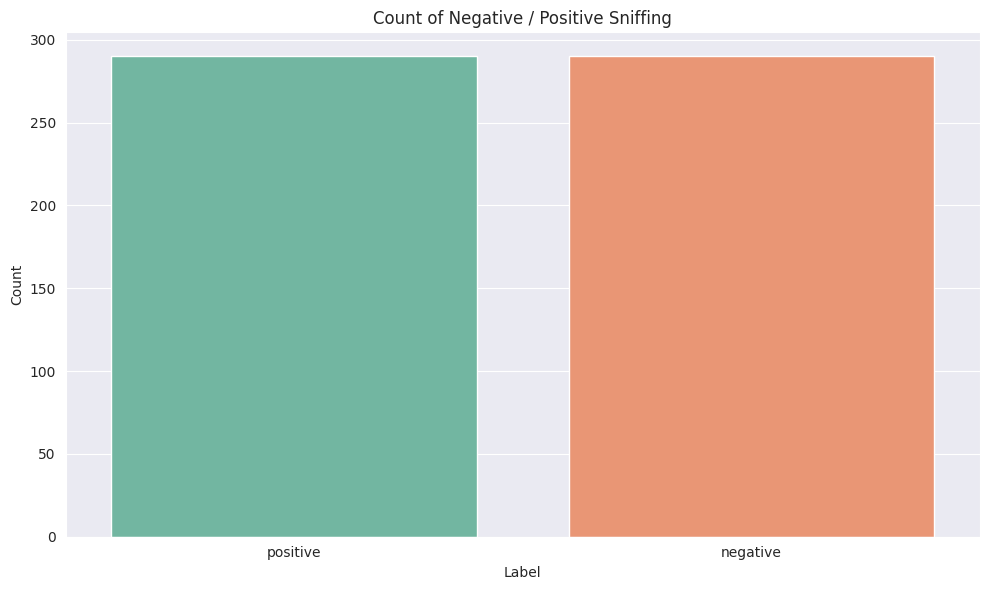

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', order=['positive', 'negative'], palette='Set2', hue = 'label', legend=False)
plt.title('Count of Negative / Positive Sniffing')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()

# <a id='toc7_'></a>[IMPORT DATA](#toc0_)

In [ ]:
sn = df.copy()

snippet_name = sn['filename']
name = snippet_name.str.split('.', expand=True)[0]
snippets = []
for n in name: 
    vid = n.split('_')[0]
    
    nr = n.split('_')[2]    
    if len(nr) == 1:
        nr = '00' + nr
    elif len(nr) == 2:
        nr = '0' + nr    
    snippets.append(vid + '_' + nr)    

sn['snippet'] = snippets
sn['vid'] = vid

# order the columns of sn
sn = sn[['filename', 'vid', 'snippet', 'duration', 'label']]
#sort by snippet
sn = sn.sort_values(by='snippet').reset_index(drop=True)

sn

,filename,vid,snippet,duration,label
0,2621_snippet_6.mp4,2678,2621_006,2.069,positive
1,2621_snippet_8.mp4,2678,2621_008,0.801,negative
2,2621_snippet_9.mp4,2678,2621_009,0.501,positive
3,2621_snippet_11.mp4,2678,2621_011,0.901,positive
4,2621_snippet_14.mp4,2678,2621_014,0.534,negative
...,...,...,...,...,...
575,3199_snippet_6.mp4,2678,3199_006,1.569,positive
576,3199_snippet_12.mp4,2678,3199_012,0.201,negative
577,3199_snippet_19.mp4,2678,3199_019,4.705,positive
578,3199_snippet_22.mp4,2678,3199_022,1.369,positive


In [31]:
sn[sn['label'] == 'positive']['duration'].describe()

count    290.000000
mean       1.929907
std        2.482766
min        0.234000
25%        0.601000
50%        1.334500
75%        2.527750
max       33.134000
Name: duration, dtype: float64

In [ ]:
sn[sn['label'] == 'negative']['duration'].describe()

count    290.000000
mean       0.676928
std        0.344219
min        0.201000
25%        0.434000
50%        0.601000
75%        0.835000
max        2.036000
Name: duration, dtype: float64

# <a id='toc8_'></a>[HISTOGRAM](#toc0_)

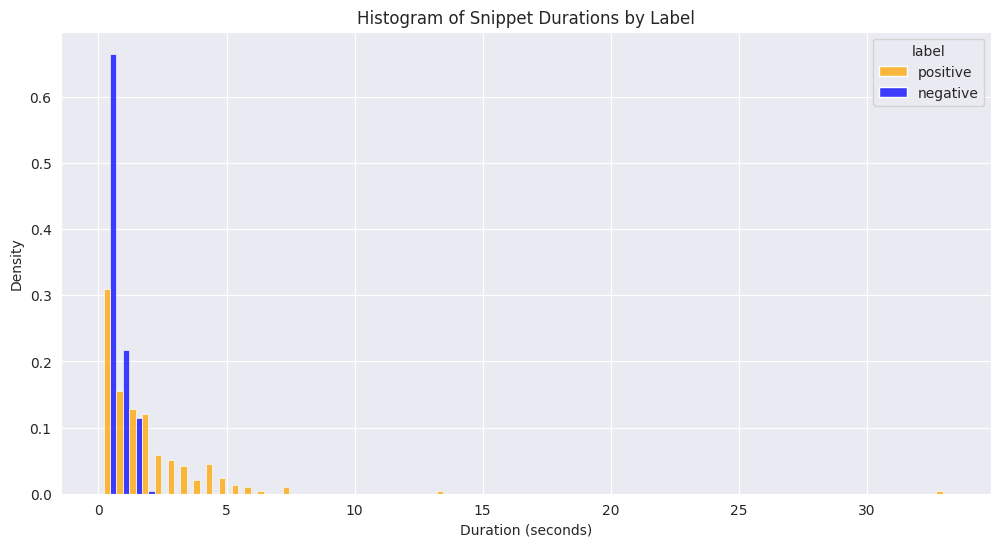

In [ ]:
min_duration = sn['duration'].min()
max_duration = sn['duration'].max()
bins = np.arange(min_duration, max_duration + 0.5, 0.5)

plt.figure(figsize=(12, 6))
sns.histplot(
    data=sn,
    x="duration",
    hue="label",
    bins=bins,
    multiple="dodge",
    stat="density",
    palette={"positive": "orange", "negative": "blue"}
)
plt.title('Histogram of Snippet Durations by Label')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.show()

# <a id='toc9_'></a>[BOXPLOT DURATION](#toc0_)

In [ ]:
selected_y = sn["duration"]
selected_x = sn["label"]

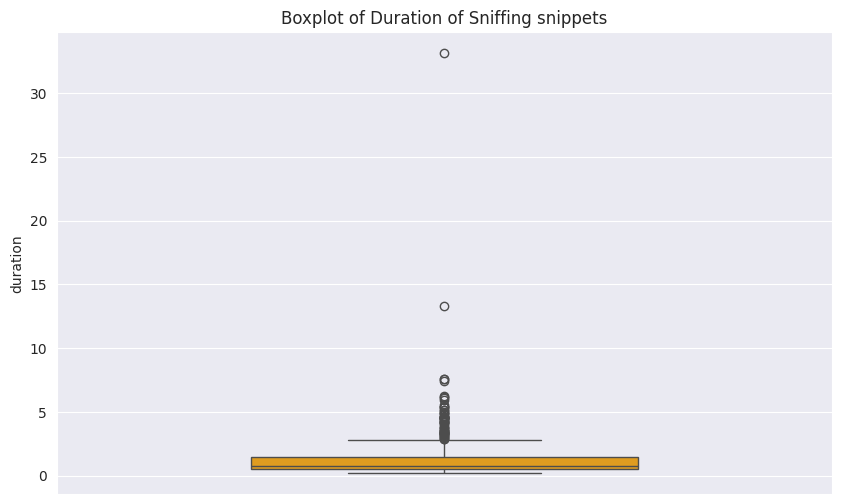

In [36]:
#plot boxplot of the duration of the snippets
plt.figure(figsize=(10, 6))

sns.boxplot(y=selected_y, color='orange', width=0.5)
plt.title('Boxplot of Duration of Sniffing snippets')

plt.show()

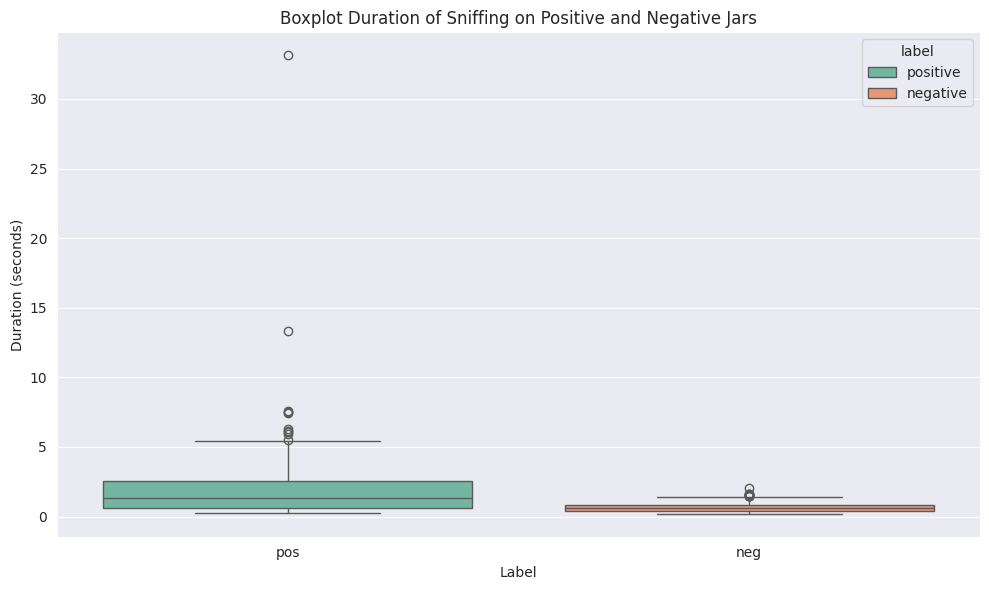

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data= sn, x = selected_x, y = selected_y, whis = 1.5, palette='Set2', hue = 'label', legend=True)
plt.title("Boxplot Duration of Sniffing on Positive and Negative Jars")
plt.xticks([1,0], ["neg", "pos"])
plt.xlabel("Label")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()

In [ ]:
sn

,filename,vid,snippet,duration,label
0,2621_snippet_1.mp4,2644,2621_001,0.668,negative
1,2621_snippet_6.mp4,2644,2621_006,2.069,positive
2,2621_snippet_7.mp4,2644,2621_007,0.368,negative
3,2621_snippet_9.mp4,2644,2621_009,0.501,positive
4,2621_snippet_11.mp4,2644,2621_011,0.901,positive
...,...,...,...,...,...
575,3199_snippet_3.mp4,2644,3199_003,0.801,negative
576,3199_snippet_5.mp4,2644,3199_005,1.635,positive
577,3199_snippet_6.mp4,2644,3199_006,1.569,positive
578,3199_snippet_19.mp4,2644,3199_019,4.705,positive


# <a id='toc10_'></a>[SPLIT TRAIN TEST](#toc0_)

In [ ]:
train_df = sn.sample(frac=0.8, random_state=42) # 546
test_df = sn.drop(train_df.index) #136
# instead of sn_no, we use sn to have all the data


print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 464
Total videos for testing: 116


In [ ]:
print(test_df['label'].value_counts())
train_df['label'].value_counts()

label
negative    67
positive    49
Name: count, dtype: int64


label
positive    241
negative    223
Name: count, dtype: int64

# <a id='toc11_'></a>[FUNCTION LOAD / CROP VIDEO](#toc0_)

### <a id='toc11_1_1_'></a>[IMAGE SIZE](#toc0_)

In [ ]:
IMG_SIZE = 224

In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

# the snippets have 30 frames per second
#so a video of 1 second has 30 frames

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

# <a id='toc12_'></a>[FUNCTION INCEPTION V3 FEATURE EXTRACTION](#toc0_)
UCF101 & action recognition using TF Hub & pretrained TF InceptionV3 model trained on ImageNet-1k dataset. 

source: https://keras.io/examples/vision/video_classification/
One of the many challenges of training video classifiers is figuring out a way to feed the videos to a network. This blog post discusses five such methods. Since a video is an ordered sequence of frames, we could just extract the frames and put them in a 3D tensor. But the number of frames may differ from video to video which would prevent us from stacking them into batches (unless we use padding). As an alternative, we can save video frames at a fixed interval until a maximum frame count is reached. In this example we will do the following:
1.Capture the frames of a video.
2.Extract frames from the videos until a maximum frame count is reached.
3.In the case, where a video's frame count is lesser than the maximum frame count we will pad the video with zeros.
Note that this workflow is identical to problems involving texts sequences. Videos of the UCF101 dataset is known to not contain extreme variations in objects and actions across frames. Because of this, it may be okay to only consider a few frames for the learning task. But this approach may not generalize well to other video classification problems. We will be using OpenCV's VideoCapture() method to read frames from videos.

We can use a pre-trained network to extract meaningful features from the extracted frames. The Keras Applications module provides a number of state-of-the-art models pre-trained on the ImageNet-1k dataset. We will be using the InceptionV3 model for this purpose.

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
    #feature_extractor = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

I0000 00:00:1750002021.823072 3004700 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# <a id='toc13_'></a>[GATED RECURRENT UNIT BIDIRECTIONAL LAYERS](#toc0_)

## <a id='toc13_1_'></a>[PARAMETERS GRU](#toc0_)

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 600

MAX_SEQ_LENGTH = 50 #50, better results than 20 and than 70
NUM_FEATURES = 2048

TF_ENABLE_ONEDNN_OPTS=0

POSITIVE_THRESHOLD = 0.45

## <a id='toc13_2_'></a>[FUNCTION VIDEO PREP](#toc0_)

In [ ]:
#The labels of the videos are strings. 
# Neural networks do not understand string values, 
# so they must be converted to some numerical form 
# before they are fed to the model. 
# Here we will use the StringLookup layer encode the class labels as integers.

label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())

[np.str_('negative'), np.str_('positive')]


In [ ]:
def prepare_all_videos(df, root_dir, MAX_SEQ_LENGTH, NUM_FEATURES):
    num_samples = len(df)
    video_paths = df["filename"].values.tolist()
    labels = df["label"].values
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

## <a id='toc13_3_'></a>[SEQUENCE MODEL GRU](#toc0_)

inspiration : https://www.jatit.org/volumes/Vol101No5/21Vol101No5.pdf

In [ ]:

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Bidirectional GRU layers capturing forward and backward patterns
    x = keras.layers.Bidirectional(
        keras.layers.GRU(32, return_sequences=True)
    )(frame_features_input, mask=mask_input)

    x = keras.layers.Bidirectional(
        keras.layers.GRU(16, return_sequences=True)
    )(x, mask=mask_input)

    x = keras.layers.Bidirectional(
        keras.layers.GRU(8)
    )(x)

# dropout rate to prevent overfitting
    x = keras.layers.Dropout(0.5)(x)

#L2 regularization (λ=0.01) to dense layers
    x = keras.layers.Dense(8, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)

    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


In [ ]:
m = get_sequence_model()
m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 64)    │    399,744 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 32)    │      7,872 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 16)        │      2,016 │ bidirectional_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        136 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         18 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 409,786 (1.56 MB)

 Trainable params: 409,786 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

## <a id='toc13_4_'></a>[PREPARE VIDEOS GRU & RUN](#toc0_)

In [ ]:
use_cudnn= True

if use_cudnn:
    os.environ['TF_USE_CUDNN'] = '1'
    print("Using cuDNN for TensorFlow")
else:
    os.environ['TF_USE_CUDNN'] = '0'
    print("Not using cuDNN for TensorFlow")


t3 = time.time()

# 30  minutes

train_data, train_labels = prepare_all_videos(train_df, training_all, MAX_SEQ_LENGTH, NUM_FEATURES)
test_data, test_labels = prepare_all_videos(test_df, training_all, MAX_SEQ_LENGTH, NUM_FEATURES)

t4 = time.time()
time_taken =( t4 - t3)/60

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Time taken to prepare all videos: {time_taken:.2f} minutes")


Using cuDNN for TensorFlow


I0000 00:00:1750002128.996733 3095416 service.cc:152] XLA service 0x1b12a650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750002128.996798 3095416 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-15 17:42:09.096375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750002129.894846 3095416 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750002136.073898 3095416 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Frame features in train set: (464, 50, 2048)
Frame masks in train set: (464, 50)
Time taken to prepare all videos: 22.94 minutes


In [52]:
t3 = time.time()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6
)


# train model
def train_model():
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )   

    seq_model = get_sequence_model() 
    
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,  
 callbacks=[checkpoint, early_stopping, reduce_lr]
 )
    

    seq_model.load_weights(filepath)
    loss, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, loss, accuracy, seq_model


history, loss, accuracy, sequence_model = train_model()

t4 = time.time()
time_taken =( t4 - t3)/60
print(f"Time taken to run GRU model: {time_taken:.2f} minutes")
print("")
print("a", loss)
print("accuracy", round((accuracy*100),2))


Epoch 1/600
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5632 - loss: 0.7655
Epoch 1: val_loss improved from inf to 0.72923, saving model to /tmp/video_classifier/ckpt.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5603 - loss: 0.7648 - val_accuracy: 0.4857 - val_loss: 0.7292 - learning_rate: 0.0010
Epoch 2/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6128 - loss: 0.7016
Epoch 2: val_loss improved from 0.72923 to 0.68684, saving model to /tmp/video_classifier/ckpt.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6129 - loss: 0.7015 - val_accuracy: 0.7500 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 3/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5704 - loss: 0.7171
Epoch 3: val_loss improved from 0.68684 to 0.65856, saving model to /tmp/video_classifier/ckpt.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5746 - loss: 0.7153 - val_accuracy: 0.7500 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 4

Frame features in train set: (474, 20, 2048)
Frame masks in train set: (474, 20)

## <a id='toc13_5_'></a>[VALIDATION ACCURACY & LOSS - GRU](#toc0_)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


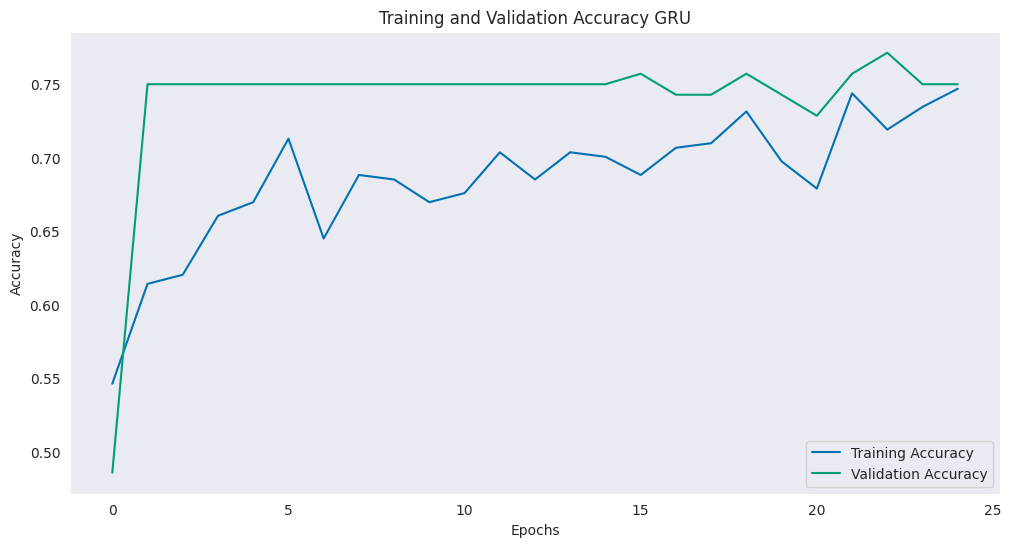

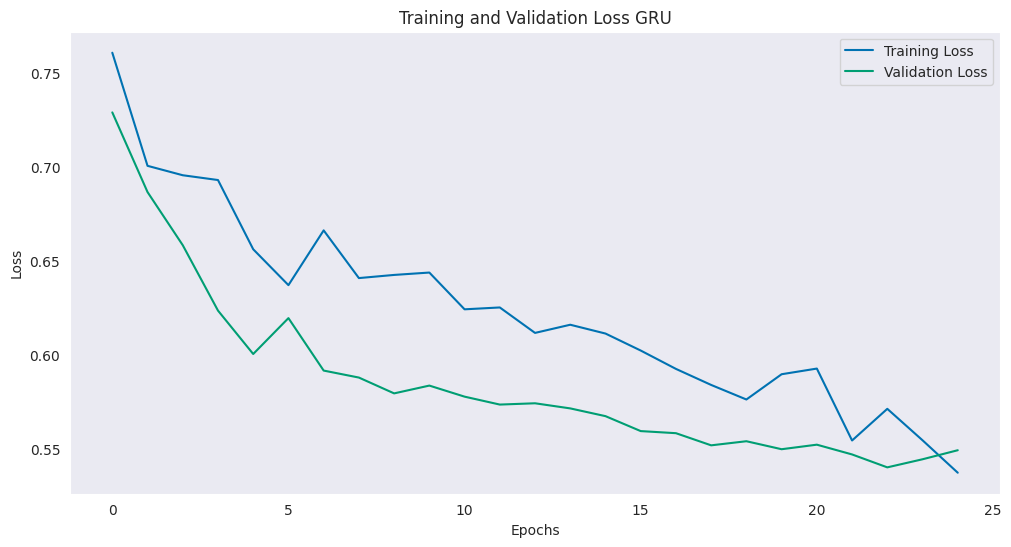

In [ ]:
print(history.history.keys())

history.history['val_accuracy']
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

history.history['val_loss']
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



In [ ]:
class_vocab = label_processor.get_vocabulary()
print("Class vocabulary:", class_vocab)


Class vocabulary: [np.str_('negative'), np.str_('positive')]


## <a id='toc13_6_'></a>[FUNCTIONS PREPARE VIDEO + SEQUENCE PREDICTION + IMAGE TO GIF](#toc0_)

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path, positive_threshold = POSITIVE_THRESHOLD, model=None):
    class_vocab = label_processor.get_vocabulary()    
    class_pos_index = class_vocab.index("positive")

    folder = training_all

    frames = load_video(os.path.join(folder, path))
    frame_features, frame_mask = prepare_single_video(frames)

       # Get predictions
    probabilities = model.predict([frame_features, frame_mask])[0]
    
    # Threshold tuning logic
    class_pos_prob = probabilities[class_pos_index]
    sorted_indices = np.argsort(probabilities)[::-1]
    
    if class_pos_prob >= positive_threshold:
        # Class 1 meets threshold - check if it's actually the max
        if sorted_indices[0] == class_pos_index:
            pred_class = class_vocab[class_pos_index]
            confidence = class_pos_prob

        else:
        #     # Class 1 meets threshold but isn't top prediction
            # pred_class = class_vocab[sorted_indices[0]]
            # confidence = probabilities[sorted_indices[0]]
            pred_class = class_vocab[class_pos_index]
            confidence = class_pos_prob

    else:
        # Class 1 below threshold - use normal argmax
        pred_class = class_vocab[sorted_indices[0]]
        confidence = probabilities[sorted_indices[0]]
    
    # Print results
    for i in sorted_indices:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    return frames, pred_class, confidence * 100

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


In [ ]:
test_df

In [ ]:
try: 
    test_df.drop(columns = ['pred', 'confidence', 'correctPrediction'], inplace=True)
except KeyError:
    print("No previous predictions found in test_df, continuing...")
test_df

No previous predictions found in test_df, continuing...


,filename,vid,snippet,duration,label
1,2621_snippet_8.mp4,2678,2621_008,0.801,negative
8,2621_snippet_22.mp4,2678,2621_022,7.408,positive
13,2621_snippet_31.mp4,2678,2621_031,6.173,positive
14,2627_snippet_1.mp4,2678,2627_001,0.534,negative
20,2628_snippet_1.mp4,2678,2628_001,0.534,positive
...,...,...,...,...,...
562,3196_snippet_7.mp4,2678,3196_007,0.735,positive
563,3197_snippet_0.mp4,2678,3197_000,3.304,positive
565,3197_snippet_3.mp4,2678,3197_003,0.534,positive
574,3199_snippet_5.mp4,2678,3199_005,1.635,positive


### <a id='toc13_6_1_'></a>[test video](#toc0_)

Test video path: 2645_snippet_17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━

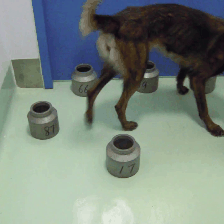

In [ ]:
# Run the sequence prediction on a test video.

test_video = np.random.choice(test_df["filename"].values.tolist())

ground_truth = df[df['filename'] == test_video]['label']

print(f"Test video path: {test_video}")

test_frames, pred, confidence = sequence_prediction(path = test_video, 
                                                    positive_threshold = POSITIVE_THRESHOLD, 
                                                    model=sequence_model)

print("")
print(f"Ground truth label: {ground_truth.values[0]}")
print(f"Predicted: {pred}")
print("confidence", round(confidence,2), "%")
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
# #play a video
# test_video = '2675_snippet_17.mp4'
# from IPython.display import Video
# video_path = os.path.join(training_all, test_video)
# Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed


### <a id='toc13_6_2_'></a>[test video negative](#toc0_)

In [ ]:
# Run the sequence prediction on a test video.
pos_test_df = test_df[test_df['label'] == 'negative']

test_video = np.random.choice(pos_test_df["filename"].values.tolist())
print(f"Test video path: {test_video}")

test_frames, pred, confidence = sequence_prediction(path = test_video, positive_threshold = POSITIVE_THRESHOLD, model=sequence_model)

print("")
ground_truth = df[df['filename'] == test_video]['label']
print(f"Ground truth label: {ground_truth.values[0]}")
print("")

print(f"Predicted: {pred}")
print("confidence", round(confidence,2), "%")
to_gif(test_frames[:MAX_SEQ_LENGTH])

### <a id='toc13_6_3_'></a>[test video positive](#toc0_)

In [ ]:

pos_test_df = test_df[test_df['label'] == 'positive']

test_video = np.random.choice(pos_test_df["filename"].values.tolist())
print(f"Test video path: {test_video}")

test_frames, pred, confidence = sequence_prediction(path = test_video, positive_threshold = POSITIVE_THRESHOLD, model=sequence_model)

print("")
ground_truth = df[df['filename'] == test_video]['label']
print(f"Ground truth label: {ground_truth.values[0]}")
print("")

print(f"Predicted: {pred}")
print("confidence", round(confidence,2), "%")
to_gif(test_frames[:MAX_SEQ_LENGTH])

# <a id='toc14_'></a>[IMPROVEMENTS IN THE DATESET BY REMOVING SNIPPETS WITH MULTIPLE JARS SNIFFINGS](#toc0_)

In [ ]:
# remove snippet from training_all, longer_all, training_pos, training_neg, longer_pos, longer_neg
def remove_snippet(snippet_name):
    paths_to_remove = [
        os.path.join(training_all, snippet_name),
        os.path.join(longer_all, snippet_name),
        os.path.join(training_pos, snippet_name),
        os.path.join(training_neg, snippet_name),
        os.path.join(longer_positives, snippet_name),
        os.path.join(longer_negatives, snippet_name)
    ]
    
    for path in paths_to_remove:
        if os.path.exists(path):
            os.remove(path)
            print(f"Removed: {path}")
        else:
            print(f"File not found: {path}")


# delete = ["2682_snippet_8.mp4",
# "2675_snippet_11.mp4",
# "2702_snippet_7.mp4",
# "2682_snippet_8.mp4",
# "2652_snippet_34.mp4",
# "2690_snippet_13.mp4",
# "3196_snippet_2.mp4",
# "2630_snippet_7.mp4"]
# for snippet in delete:
#     remove_snippet(snippet)
    


# <a id='toc15_'></a>[FOR TEST DATA : PREDICTION VS GROUND TRUTH GRU](#toc0_)

In [ ]:
#test_df.drop(columns= ['pred'	,'confidence',	'correctPrediction'], inplace=True)
test_df


,filename,vid,snippet,duration,label
1,2621_snippet_8.mp4,2678,2621_008,0.801,negative
8,2621_snippet_22.mp4,2678,2621_022,7.408,positive
13,2621_snippet_31.mp4,2678,2621_031,6.173,positive
14,2627_snippet_1.mp4,2678,2627_001,0.534,negative
20,2628_snippet_1.mp4,2678,2628_001,0.534,positive
...,...,...,...,...,...
562,3196_snippet_7.mp4,2678,3196_007,0.735,positive
563,3197_snippet_0.mp4,2678,3197_000,3.304,positive
565,3197_snippet_3.mp4,2678,3197_003,0.534,positive
574,3199_snippet_5.mp4,2678,3199_005,1.635,positive


In [ ]:

t5 = time.time()

test_df['pred'] = test_df['filename'].apply(lambda x: sequence_prediction(path = x,positive_threshold = POSITIVE_THRESHOLD, model=sequence_model)[1])
test_df['confidence'] = test_df['filename'].apply(lambda x: sequence_prediction(path = x,positive_threshold = POSITIVE_THRESHOLD, model=sequence_model)[2])
test_df["correctPrediction"] = test_df["pred"] == test_df["label"]

# Save the predictions to a CSV file
test_df.to_csv("models/gru/gru_test_predictions.csv", index=False)

t6 = time.time()
time_taken =( t6 - t5)/60
print(f"Time taken to run the predictions on the test set: {time_taken:.2f} minutes")


# count plot of the errors
plt.figure(figsize=(10, 6))
sns.countplot(data=test_df, x='correctPrediction', order=[True, False])
plt.title('Count of Errors in Predictions')
plt.xlabel('Correct Prediction GRU')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
test_df['correctPrediction'].value_counts()

# Calculate accuracy
accuracy = accuracy_score(test_df['label'], test_df['pred'])
print(f"Accuracy: {accuracy * 100:.2f}%")
# Calculate precision, recall, and F1-score

from sklearn.metrics import classification_report
report = classification_report(test_df['label'], test_df['pred'], target_names=['negative', 'positive'])
print("Classification Report:\n", report)


In [ ]:
##### NEXT STEP = SAVE MODEL AND WEIGHTS
##### ONLY WHEN ACCURACY AND RECALL IS SATISFACTORY !!!!

# check 

# destination_folder = "models/gru/"
# os.makedirs(destination_folder, exist_ok=True)

# # # Save the model
# sequence_model.save("models/gru/my_video_classifier_model.h5")

# # Save the label processor
# with open("models/gru/label_processor.pkl", "wb") as f:
#     pickle.dump(label_processor, f)

# # Save the feature extractor
# feature_extractor.save("models/gru/my_feature_extractor_model.h5")

# # Save the sequence model
# sequence_model.save("models/gru/my_sequence_model.h5")
# # Save the training and testing data
# with open("models/gru/train_data.pkl", "wb") as f:
#     pickle.dump(train_data, f)

## <a id='toc15_1_'></a>[CLASSIFICATION REPORT](#toc0_)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(test_df['label'], test_df['pred'], target_names=['negative', 'positive'])
print("Classification Report:\n", report)

# <a id='toc16_'></a>[COMPLETE DATASET COUNT & PLOT](#toc0_)

In [ ]:
all_true_pred = pd.read_csv("models/gru/all_true_pred.csv")
#all_true_pred = pd.read_csv("/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/model/models/gru/all_true_pred35.csv")
# accuracy 50 on positive 84 on negative, recall 0.8 on positive and 0.58 on negative
all_true_pred.shape

# if value in column pred is not the same as in column label, then add a new column called correctPrediction with value False, otherwise True
all_true_pred['correctPrediction'] = all_true_pred['predicted_class'] == all_true_pred['label']
print(all_true_pred['correctPrediction'].value_counts())

In [35]:
#allSn = dfAll.copy()
allSn = all_true_pred.copy()
dfAll = all_true_pred.copy()

snippet_name = allSn['filename']
name = snippet_name.str.split('.', expand=True)[0]
snippets = []
for n in name: 
    vid = n.split('_')[0]
    
    nr = n.split('_')[2]    
    if len(nr) == 1:
        nr = '00' + nr
    elif len(nr) == 2:
        nr = '0' + nr    
    snippets.append(vid + '_' + nr)    

allSn['snippet'] = snippets
allSn['vid'] = vid

# order the columns of sn
allSn = allSn[['filename', 'vid', 'snippet', 'duration', 'label']]
#sort by snippet
allSn = allSn.sort_values(by='snippet').reset_index(drop=True)

allSn

,filename,vid,snippet,duration,label
0,2621_snippet_1.mp4,3199,2621_001,0.668,negative
1,2621_snippet_5.mp4,3199,2621_005,0.668,negative
2,2621_snippet_6.mp4,3199,2621_006,2.069,positive
3,2621_snippet_7.mp4,3199,2621_007,0.368,negative
4,2621_snippet_8.mp4,3199,2621_008,0.801,negative
...,...,...,...,...,...
845,3199_snippet_11.mp4,3199,3199_011,0.301,negative
846,3199_snippet_12.mp4,3199,3199_012,0.201,negative
847,3199_snippet_19.mp4,3199,3199_019,4.705,positive
848,3199_snippet_22.mp4,3199,3199_022,1.369,positive


In [ ]:
print(allSn[allSn['label'] == 'positive']['duration'].describe())
print(allSn[allSn['label'] == 'negative']['duration'].describe())

count    294.000000
mean       1.921248
std        2.467373
min        0.234000
25%        0.601000
50%        1.334500
75%        2.486250
max       33.134000
Name: duration, dtype: float64
count    556.000000
mean       0.672815
std        0.344845
min        0.167000
25%        0.434000
50%        0.601000
75%        0.835000
max        2.036000
Name: duration, dtype: float64


## <a id='toc16_1_'></a>[PROBABILITY AND DISTRIBUTION](#toc0_)

### <a id='toc16_1_1_'></a>[DURATION](#toc0_)

/root/miniconda3/envs/aai5/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


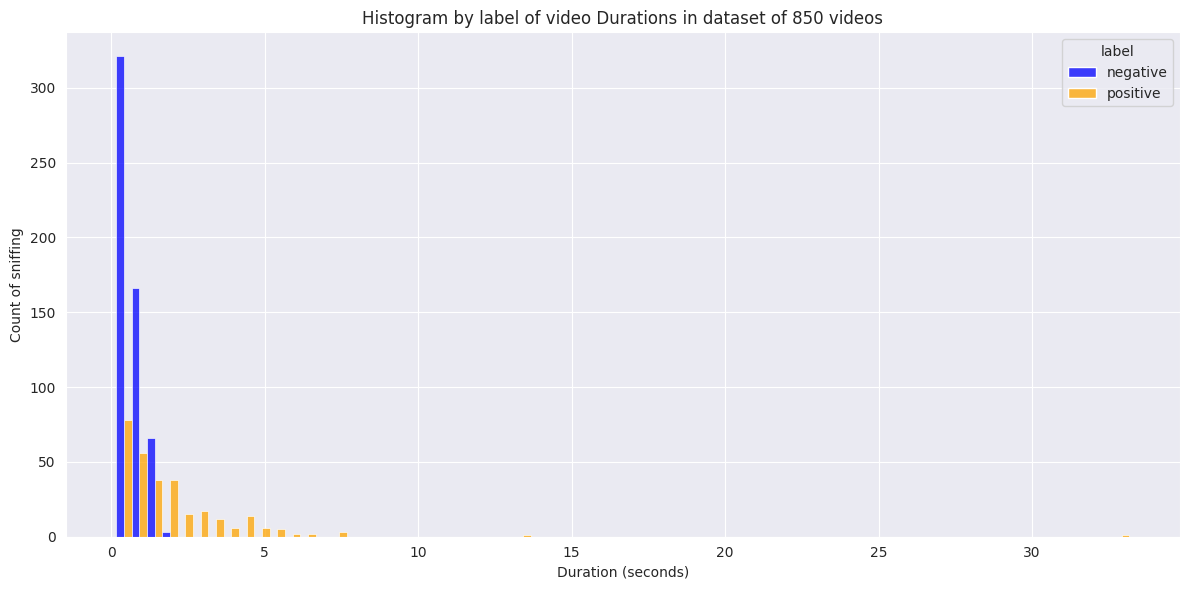

In [ ]:
min_duration = allSn['duration'].min()
max_duration = allSn['duration'].max()
bins = np.arange(min_duration, max_duration + 0.5, 0.5)

counts = allSn['label'].count()

plt.figure(figsize=(12, 6))
sns.histplot(
    data=allSn,
    x="duration",
    hue="label",
    bins=bins,
    multiple="dodge",
    #stat="density",
    palette={"positive": "orange", "negative": "blue"}
)
plt.title(f'Histogram by label of video Durations in dataset of {counts} videos')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count of sniffing')
plt.tight_layout()
plt.show()

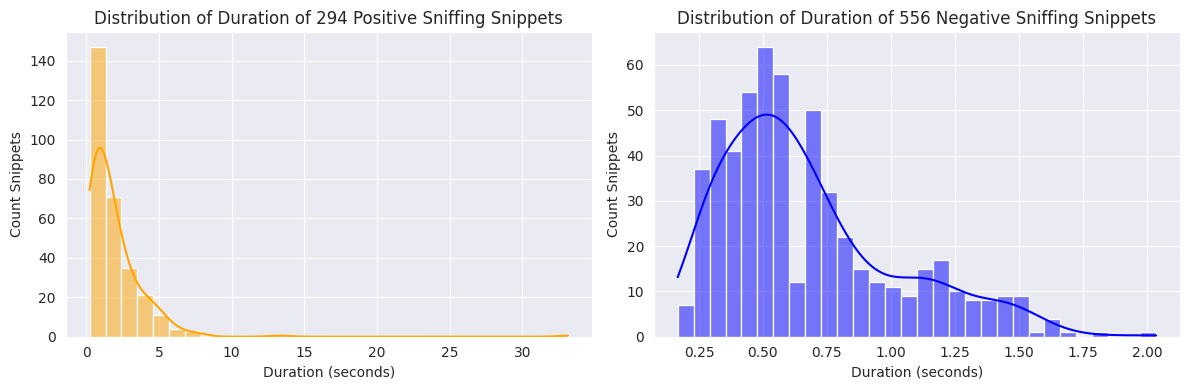

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract positive and negative duration data
posDist = allSn[allSn['label'] == 'positive']['duration']
pLen= posDist.shape[0]
negDist = allSn[allSn['label'] == 'negative']['duration']
nLen = negDist.shape[0]

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot positive durations
sns.histplot(posDist, kde=True, color='orange', bins=30, ax=axes[0])
axes[0].set_title(f'Distribution of Duration of {pLen} Positive Sniffing Snippets')
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Count Snippets')
axes[0].grid(True)

# Plot negative durations
sns.histplot(negDist, kde=True, color='blue', bins=30, ax=axes[1])
axes[1].set_title(f'Distribution of Duration of {nLen} Negative Sniffing Snippets')
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Count Snippets')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [25]:
allDist = allSn[['duration', 'label']].copy()


In [27]:
#needed for probability distribution
from scipy import stats
import pandas as pd
from scipy.stats import binomtest


seconds = 1.7


allDist = allSn[['duration', 'label']].copy()



# Ensure labels are binary (if not already converted)
allDist['label0_1'] = allDist['label'].map({'positive': 1, 'negative': 0})


filtered_df = allDist[allDist['duration'] >= seconds]
# Calculate binomial parameters
n = len(filtered_df)  # Total trials or nr of snippets with duration ≥ x seconds

#positive label 
label_positive = 'positive'
k = filtered_df[filtered_df['label'] == label_positive].shape[0]  # Count of positive labels with duration ≥ x seconds

# negative label
label_negative = 'negative'
k2 = filtered_df[filtered_df['label'] == label_negative].shape[0]  

if n == 0:
    print(f"No data points with duration {seconds} seconds")
else:
    # Calculate observed probability
    p_observed_pos = k / n
    p_observed_neg = k2 / n
    
    # Get binomial confidence interval
    result = binomtest(k, n=n, p=0.5, alternative='two-sided')
    ci = result.proportion_ci()

    result2 = binomtest(k2, n=n, p=0.5, alternative='two-sided')
    ci2 = result2.proportion_ci()
    
    print("")
    print("--------------")
    print(f"Probability of {label_positive} sniffing if duration >= {seconds} seconds : {100*p_observed_pos:.2f}%")
    print(f"95% CI: [{100*ci.low:.2f}%, {100*ci.high:.2f}]%")
    print("")
    print(f"Probability of {label_negative} sniffing if duration >= {seconds} seconds : {100*p_observed_neg:.2f}%")
    print(f"95% CI: [{100*ci2.low:.2f}%, {100*ci2.high:.2f}]%")
  

### explained
print(f"\nBased on the data, the real probability ")
print(f"of the dog sniffing on a {label_positive} jar ")
print(f"for a duration longer than {seconds} seconds we are {round(p_observed_pos*100,2)}% sure")
print(f"the probability is between: {round(ci.low*100,2)} % and {round(ci.high*100,2)} %")
print(f"Of the {n} sniffings longer than {seconds} seconds, {k} were on a {label_positive} jar.")

print(f"\nBased on the data, the real probability ")
print(f"of the dog sniffing on a {label_negative} jar ")
print(f"for a duration longer than {seconds} seconds we are {round(p_observed_neg*100,2)}% sure")
print(f"the probability is between: {round(ci2.low*100,2)} % and {round(ci2.high*100,2)} %")
print(f"Of the {n} sniffings longer than {seconds} seconds, {k2} were on a {label_negative} jar.")



--------------
Probability of positive sniffing if duration >= 1.7 seconds : 98.36%
95% CI: [94.20%, 99.80]%

Probability of negative sniffing if duration >= 1.7 seconds : 1.64%
95% CI: [0.20%, 5.80]%

Based on the data, the real probability 
of the dog sniffing on a positive jar 
for a duration longer than 1.7 seconds we are 98.36% sure
the probability is between: 94.2 % and 99.8 %
Of the 122 sniffings longer than 1.7 seconds, 120 were on a positive jar.

Based on the data, the real probability 
of the dog sniffing on a negative jar 
for a duration longer than 1.7 seconds we are 1.64% sure
the probability is between: 0.2 % and 5.8 %
Of the 122 sniffings longer than 1.7 seconds, 2 were on a negative jar.


In [ ]:
#play a video for a positive jar to illustrate the duration
folder = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/training_all/"
test_video = '3197_snippet_13.mp4'
from IPython.display import Video
video_path = os.path.join(folder, test_video)
Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed

# <a id='toc17_'></a>[CORRELATION AND PEARSON](#toc0_)
This heatmap visualizes the correlation coefficients between the 'duration' and 'label' variables. In your code, the 'label' column is mapped to binary values ('positive' = 1, 'negative' = 0), allowing you to compute Pearson correlation coefficients. The values in the heatmap indicate the strength and direction of the linear relationship between these variables:

Values close to 1 indicate a strong positive correlation.

Values close to -1 indicate a strong negative correlation.

Values near 0 indicate little or no linear correlation.

The diagonal will always show 1 (perfect correlation with itself), while the off-diagonal shows the correlation between 'duration' and 'label'. This helps you quickly assess whether higher durations are associated with positive or negative labels in your dataset.

[[1.         0.37342098]
 [0.37342098 1.        ]]


np.float64(0.37342098027134923)

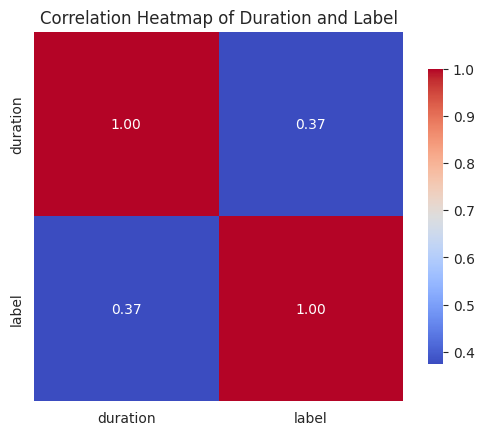

In [ ]:

corrDf = allSn[['duration', 'label']].copy()
corrDf['label'] = corrDf['label'].map({'positive': 1, 'negative': 0})  

corrcoef = corrDf.corr()
corrcoef.head()
sns.heatmap(data=corrcoef, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Duration and Label')


# correlation between 2 known columns
# define columns 
column01 = corrDf["duration"]
column02 = corrDf["label"]

# correlation
correlation = np.corrcoef(column01,column02)
print(correlation)

# correlation between 2 columns - alternative

column01.corr(column02)

In [29]:
column01 = corrDf["duration"]
column02 = corrDf["label"]


<Figure size 2000x600 with 0 Axes>

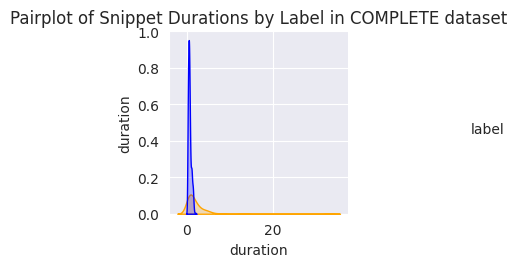

In [30]:
plt.figure(figsize=(20, 6))
sns.pairplot(data=allSn, hue='label', vars=['duration'], palette={"positive": "orange", "negative": "blue"})
plt.title('Pairplot of Snippet Durations by Label in COMPLETE dataset')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.show()

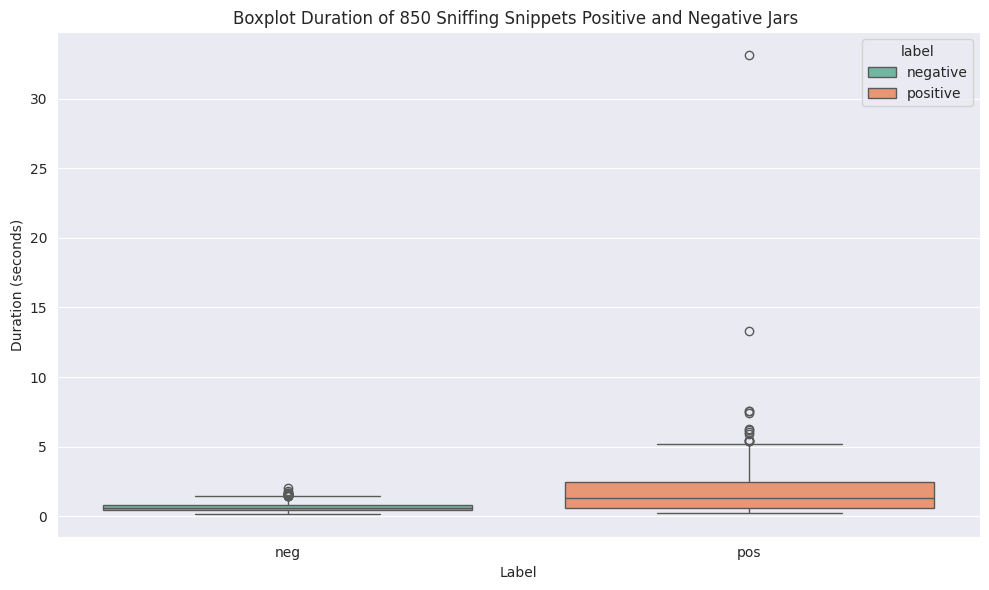

In [31]:
selected_y = allSn["duration"]
selected_x = allSn["label"]
count = len(selected_y)
plt.figure(figsize=(10, 6))
sns.boxplot(data= allSn, x = selected_x, y = selected_y, whis = 1.5, palette='Set2', hue = 'label', legend=True)
plt.title(f"Boxplot Duration of {count} Sniffing Snippets Positive and Negative Jars ")
plt.xticks([0,1], ["neg", "pos"])
plt.xlabel("Label")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()

In [ ]:
end_notebook = time.time()
time_taken = (end_notebook - start_notebook) / 60
print(f"Total time taken for the entire notebook: {time_taken:.2f} minutes")
## 77 MIN

In [ ]:
# play video
from IPython.display import Video
video_path = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/2643Round1.mp4"
Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed
# play video

there are more negative than positive jars. The dog must learn to detect a positive jar among a lot of negative ones. 

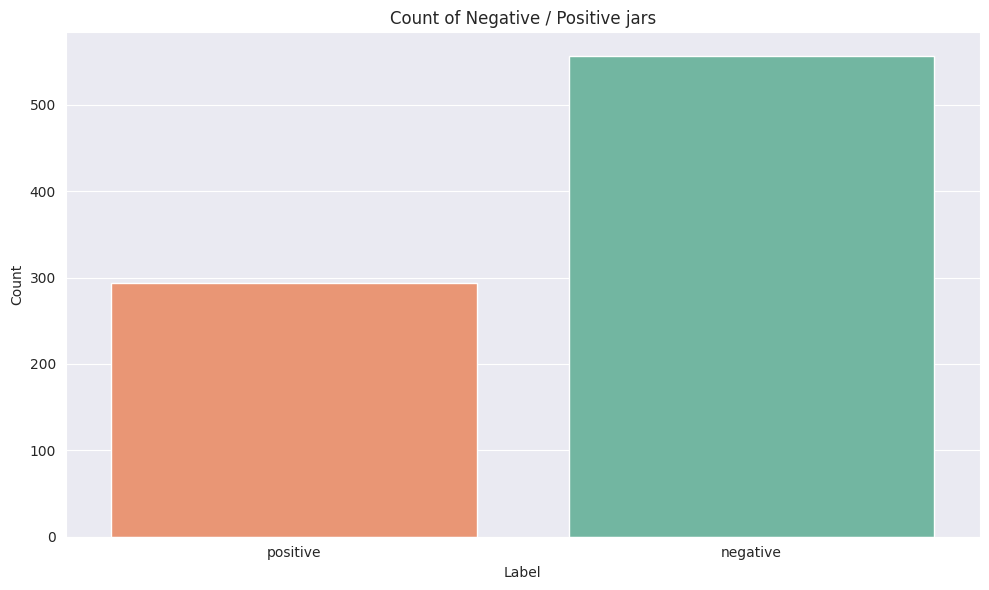

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dfAll, x='label', order=['positive', 'negative'], palette='Set2', hue = 'label', legend=False)
plt.title('Count of Negative / Positive jars')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()

the dogs lies down and in 81% of the times if it is a positive jar. 

# <a id='toc18_'></a>[CORRECTNESS DOG'S DETECTION](#toc0_)

Dog detected Parkinson correctly by lying down in 81% of the cases
Dog detected Parkinson not correctly by lying down: 19%


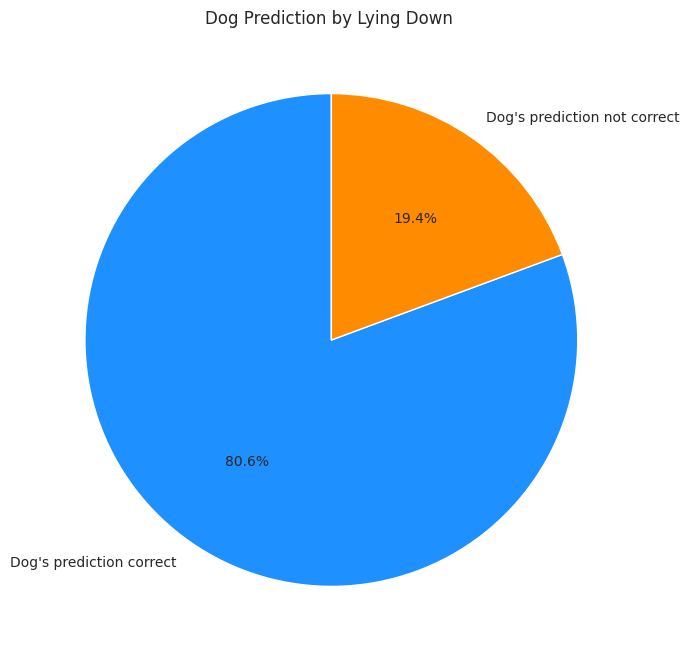

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nr_snif = 666 + 518 + 579  # number of times the dog sniffed jars
nr_pos_jar = 130 + 175 + 172  # number of sniffed positive jars
nr_neg_jar = 412 + 407 + 388  # number of negative jars
nr_lie_down = 48 + 65 + 42  # number of times the dog lies down
nr_dog_correct = 36 + 51 + 38  # number of times the dog lies down before a positive jar
nr_dog_not_correct = 12 + 14 + 4  # number of times the dog lies down before a negative jar

# Create the DataFrame with scalar values
dog_cor = {
    'nr_lie_down': nr_lie_down,
    'nr_dog_correct': nr_dog_correct,
    'nr_dog_not_correct': nr_dog_not_correct
}
dog_correct = pd.DataFrame([dog_cor])

# Print percentages
print(f"Dog detected Parkinson correctly by lying down in {dog_correct['nr_dog_correct'].sum() / dog_correct['nr_lie_down'].sum() * 100:.0f}% of the cases")
print(f"Dog detected Parkinson not correctly by lying down: {dog_correct['nr_dog_not_correct'].sum() / dog_correct['nr_lie_down'].sum() * 100:.0f}%")

# Pie chart colors as a list
colors = ['dodgerblue', 'darkorange']

# Values and labels for the pie chart
values = dog_correct[['nr_dog_correct', 'nr_dog_not_correct']].values.flatten()
labels = ["Dog's prediction correct", "Dog's prediction not correct"]

plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Dog Prediction by Lying Down ')
plt.show()



so we looked at the videos and cut the videos in shorter snippets 
when the dog puts its nose in a jar, takes out its nose and the behavior it shows until it puts its nose in another jar. 

We call this moments: sniffing snippets 

We saw a difference in the duration of the snippets with a positive or a negative jar. 

For a positive jar, the dog lies down before it goes to a next jar. 
Or it just takes more time to be sure it is a positive jar. 

If it is a negative jar, the dog goes very fast to the next one.
It is trained to detect the positive jar as fast as possible. 

That is why we analysed the duration of a sniffing snippet in relation to the label positive or negative.


In [38]:
# show a negative jar
#play a video
folder = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/training_all/"
test_video = "2676_snippet_3.mp4"

from IPython.display import Video
video_path = os.path.join(folder, test_video)
Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed


In [ ]:
#show a positive jar
folder = "/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/balancedDataset/training_all/"
test_video = '3197_snippet_13.mp4'
from IPython.display import Video
video_path = os.path.join(folder, test_video)
Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed

In [39]:
min_duration = allSn['duration'].min()
max_duration = allSn['duration'].max()

print(f"The longest sniffing snippet is {max_duration:.2f} seconds")
print(f"The shortest sniffing snippet is {min_duration:.2f} seconds")


The longest sniffing snippet is 33.13 seconds
The shortest sniffing snippet is 0.17 seconds


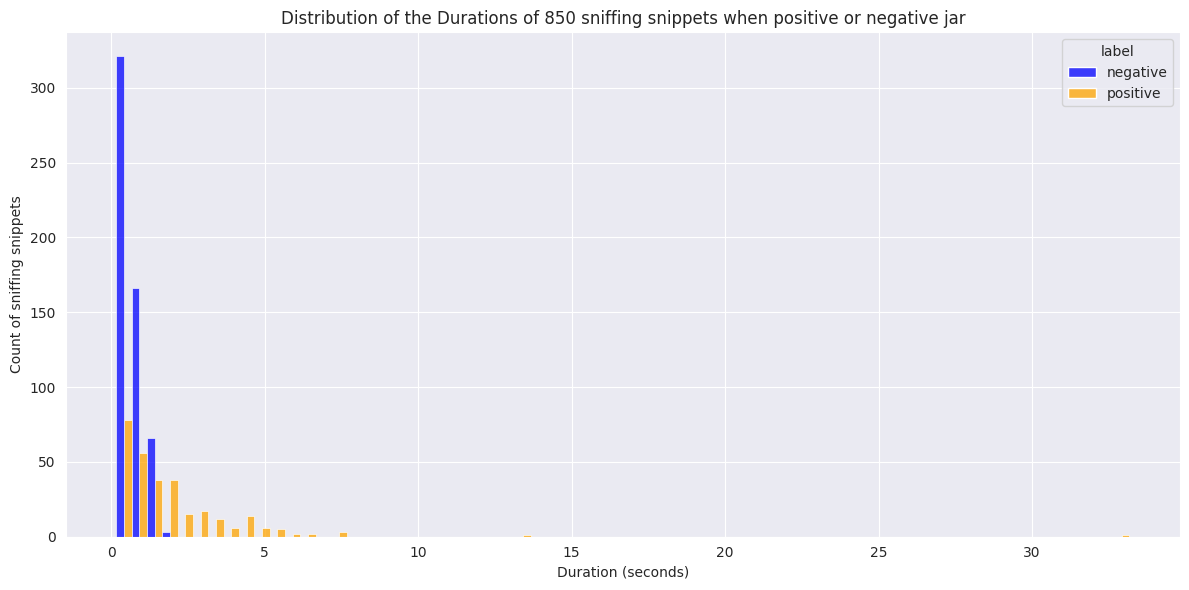

In [40]:
min_duration = allSn['duration'].min()
max_duration = allSn['duration'].max()
bins = np.arange(min_duration, max_duration + 0.5, 0.5)

counts = allSn['label'].count()

plt.figure(figsize=(12, 6))
sns.histplot(
    data=allSn,
    x="duration",
    hue="label",
    bins=bins,
    multiple="dodge",
    #stat="density",
    palette={"positive": "orange", "negative": "blue"}
)
plt.title(f'Distribution of the Durations of {counts} sniffing snippets when positive or negative jar')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count of sniffing snippets')
plt.tight_layout()
plt.show()

In [41]:
#needed for probability distribution
from scipy import stats
import pandas as pd
from scipy.stats import binomtest

seconds = 1.7

allDist = allSn[['duration', 'label']].copy()

# Ensure labels are binary (if not already converted)
allDist['label0_1'] = allDist['label'].map({'positive': 1, 'negative': 0})


filtered_df = allDist[allDist['duration'] >= seconds]
# Calculate binomial parameters
n = len(filtered_df)  # Total trials or nr of snippets with duration ≥ x seconds

#positive label 
label_positive = 'positive'
k = filtered_df[filtered_df['label'] == label_positive].shape[0]  # Count of positive labels with duration ≥ x seconds

# negative label
label_negative = 'negative'
k2 = filtered_df[filtered_df['label'] == label_negative].shape[0]  

if n == 0:
    print(f"No data points with duration {seconds} seconds")
else:
    # Calculate observed probability
    p_observed_pos = k / n
    p_observed_neg = k2 / n
    
    # Get binomial confidence interval
    result = binomtest(k, n=n, p=0.5, alternative='two-sided')
    ci = result.proportion_ci()

    result2 = binomtest(k2, n=n, p=0.5, alternative='two-sided')
    ci2 = result2.proportion_ci()
    
    # print("")
    # print("--------------")
    # print(f"Probability of {label_positive} sniffing if duration >= {seconds} seconds : {100*p_observed_pos:.2f}%")
    # print(f"95% CI: [{100*ci.low:.2f}%, {100*ci.high:.2f}]%")
    # print("")
    # print(f"Probability of {label_negative} sniffing if duration >= {seconds} seconds : {100*p_observed_neg:.2f}%")
    # print(f"95% CI: [{100*ci2.low:.2f}%, {100*ci2.high:.2f}]%")
  

### explained
# print(f"\nBased on the data, the real probability ")
# print(f"of the dog sniffing on a {label_positive} jar ")
# print(f"for a duration longer than {seconds} seconds is {round(p_observed_pos*100,2)}%")
# print(f"and we are 95% sure that the probability is between: {round(ci.low*100,2)} % and {round(ci.high*100,2)} %")
# print(f"Of the {n} sniffings longer than {seconds} seconds, {k} were on a {label_positive} jar.")

# print(f"\nBased on the data, the real probability ")
# print(f"of the dog sniffing on a {label_negative} jar ")
# print(f"for a duration longer than {seconds} seconds is {round(p_observed_neg*100,2)}%")
# print(f"and we are 95% sure that the probability is between: {round(ci2.low*100,2)} % and {round(ci2.high*100,2)} %")
# print(f"Of the {n} sniffings longer than {seconds} seconds, {k2} were on a {label_negative} jar.")


print(f"When the dog sniffs a jar for a duration longer than {seconds} seconds:")
print(f"the probablity that it is sniffing a {label_positive} jar is between {round(ci.low*100,2)} % and {round(ci.high*100,2)} %")
print(f"the probability that it is sniffing a {label_negative} jar is between {round(ci2.low*100,2)} % and {round(ci2.high*100,2)} %")


When the dog sniffs a jar for a duration longer than 1.7 seconds:
the probablity that it is sniffing a positive jar is between 94.2 % and 99.8 %
the probability that it is sniffing a negative jar is between 0.2 % and 5.8 %


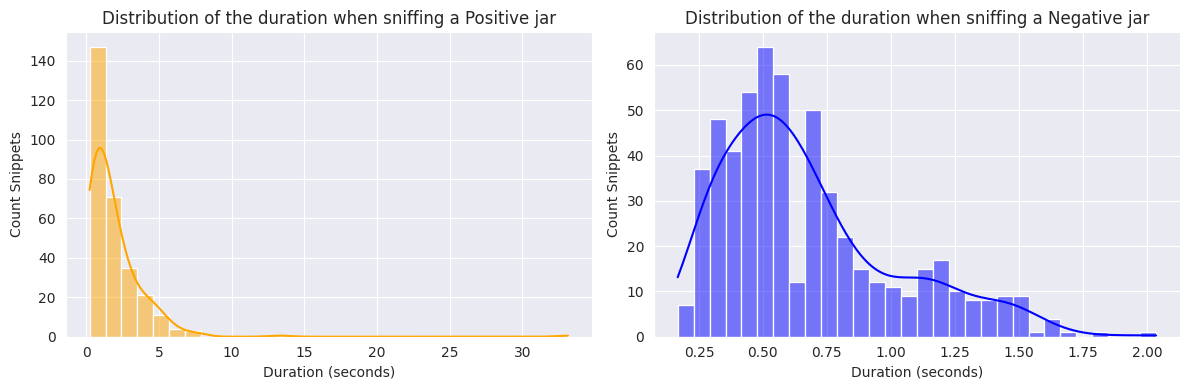

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract positive and negative duration data
posDist = allSn[allSn['label'] == 'positive']['duration']
negDist = allSn[allSn['label'] == 'negative']['duration']

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot positive durations
sns.histplot(posDist, kde=True, color='orange', bins=30, ax=axes[0])
axes[0].set_title('Distribution of the duration when sniffing a Positive jar')
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Count Snippets')
axes[0].grid(True)

# Plot negative durations
sns.histplot(negDist, kde=True, color='blue', bins=30, ax=axes[1])
axes[1].set_title('Distribution of the duration when sniffing a Negative jar')
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Count Snippets')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# <a id='toc19_'></a>[RUN ON TOTAL DATASET](#toc0_)

In [ ]:

t7 = time.time()
path = longer_all

def create_path(x):
    filepath = os.path.join(path, x)
    return filepath


allSn1['pred'] = allSn1['filename'].apply(lambda x: sequence_prediction(path = create_path(x),positive_threshold = POSITIVE_THRESHOLD, model=sequence_model)[1])
allSn1['confidence'] = allSn1['filename'].apply(lambda x: sequence_prediction(path = create_path(x),positive_threshold = POSITIVE_THRESHOLD, model=sequence_model)[2])
allSn1["correctPrediction"] = allSn1["pred"] == allSn1["label"]

# Save the predictions to a CSV file
allSn.to_csv("models/gru/gru_allSn1_predictions.csv", index=False)

t8 = time.time()
time_taken =(t8 - t7)/60
print(f"Time taken to run the predictions on all the snippets : {time_taken:.2f} minutes")


# <a id='toc20_'></a>[NEGATIVE BUT CLASSIFIED AS POSITIVE: OTHER BEHAVIOR,](#toc0_)

## <a id='toc20_1_'></a>[nose deeper in jar](#toc0_)

In [ ]:
negative_snippet_predicted_as_positive = "2630_snippet_7.mp4" 
path_to_snippet = os.path.join(longer_negatives, negative_snippet_predicted_as_positive)
Video(path_to_snippet, embed=True, width=400, height=300)

## <a id='toc20_2_'></a>[skipping a jar](#toc0_)

In [ ]:
negative_snippet_predicted_as_positive = "2671_snippet_11.mp4" 
path_to_snippet = os.path.join(longer_negatives, negative_snippet_predicted_as_positive)
Video(path_to_snippet, embed=True, width=400, height=300)

## <a id='toc20_3_'></a>[turning around](#toc0_)

In [ ]:
# negative_snippet_predicted_as_positive = "2652_snippet_34.mp4" 
# path_to_snippet = os.path.join(longer_negatives, negative_snippet_predicted_as_positive)
# Video(path_to_snippet, embed=True, width=400, height=300)



## <a id='toc20_4_'></a>[almost lying](#toc0_)

In [ ]:
negative_snippet_predicted_as_positive = "2638_snippet_23.mp4" 
path_to_snippet = os.path.join(longer_negatives, negative_snippet_predicted_as_positive)
Video(path_to_snippet, embed=True, width=400, height=300)

## <a id='toc20_5_'></a>[slower sniffing](#toc0_)

In [ ]:
negative_snippet_predicted_as_positive = "2686_snippet_16.mp4"
path_to_snippet = os.path.join(longer_negatives, negative_snippet_predicted_as_positive)
Video(path_to_snippet, embed=True, width=400, height=300)

In [ ]:
allSn

# <a id='toc21_'></a>[PREDICT NEGATIVE SNIPPETS AND VIEW THOSE PREDICTED AS POSITIVE](#toc0_)

In [ ]:
# take a random sample of ...  videos from the allSn DataFrame where the label is nega


def negative_predicted_as_pos(snippets):  
    
        
    predicted_as_pos = []      
    for snippet in snippets:
        path_to_snippet = os.path.join(longer_negatives, snippet)
    

        frames, pred, confidence = sequence_prediction(path = path_to_snippet, positive_threshold = POSITIVE_THRESHOLD, model=sequence_model)

        print("")
        ground_truth = allSn[allSn['filename'] == snippet]['label']
        print("PREDICTED", pred)
        if pred == 'positive':
        
            print(path_to_snippet)
            print(f"Ground truth label: {ground_truth.values[0]}")
        
            print(f"Predicted: {pred}")
            print("confidence", confidence)
            to_gif(frames[:MAX_SEQ_LENGTH])
            predicted_as_pos.append(path_to_snippet)

    return predicted_as_pos
        

negatives = allSn[allSn['label'] == 'negative'].sample(n=42)    
snippets = negatives['filename'].values.tolist()

pn = negative_predicted_as_pos(snippets)

In [ ]:
pn

In [ ]:

negative_snippet_predicted_as_positive =  "2642_snippet_19.mp4"
path_to_snippet = os.path.join(longer_negatives, negative_snippet_predicted_as_positive)
Video(path_to_snippet, embed=True, width=400, height=300)


In [ ]:
for f in pn:
    f1 = f.split('/')
    print(f1[-1])  
    

In [ ]:

# Show a negative jar detected as positive
from IPython.display import Video
video_path = os.path.join(folder, test_video)
Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed

In [ ]:
# show a negative jar detected as positive
test_video = '2690_snippet_1.mp4'
from IPython.display import Video
video_path = os.path.join(training_all, test_video)
Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed


In [ ]:
# use csv in "models/gru/gru_test_predictions.csv" to analyse the predictions
#story_df = pd.read_csv("models/gru/gru_test_predictions.csv")
story_df= all_true_pred.copy()

# <a id='toc22_'></a>[FALSE NEGATIVES](#toc0_)

In [ ]:
a = story_df
b = a[a['correctPrediction'] == False]
c = b[b['label'] == 'positive']
c

,filename,vid,snippet,duration,label,predicted_class,correctPrediction
5,2621_snippet_9.mp4,3199,2621_009,0.501,positive,negative,False
6,2621_snippet_11.mp4,3199,2621_011,0.901,positive,negative,False
11,2621_snippet_17.mp4,3199,2621_017,0.434,positive,negative,False
34,2628_snippet_1.mp4,3199,2628_001,0.534,positive,negative,False
37,2628_snippet_9.mp4,3199,2628_009,1.168,positive,negative,False
...,...,...,...,...,...,...,...
779,2698_snippet_5.mp4,3199,2698_005,0.735,positive,negative,False
780,2698_snippet_6.mp4,3199,2698_006,0.668,positive,negative,False
788,2702_snippet_1.mp4,3199,2702_001,0.368,positive,negative,False
789,2702_snippet_2.mp4,3199,2702_002,0.935,positive,negative,False


In [ ]:
# show a positive jar detected as negative
test_video = '2686_snippet_22.mp4'
from IPython.display import Video
video_path = os.path.join(training_all, test_video)
Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed

# <a id='toc23_'></a>[FALSE POSITIVES](#toc0_)

In [ ]:
a = story_df
b = a[a['correctPrediction'] == False]
c = b[b['label'] == 'negative']
c

,filename,vid,snippet,duration,label,predicted_class,correctPrediction
8,2621_snippet_14.mp4,3199,2621_014,0.534,negative,positive,False
21,2621_snippet_29.mp4,3199,2621_029,1.102,negative,positive,False
68,2630_snippet_14.mp4,3199,2630_014,1.102,negative,positive,False
79,2631_snippet_8.mp4,3199,2631_008,0.501,negative,positive,False
85,2631_snippet_15.mp4,3199,2631_015,0.701,negative,positive,False
...,...,...,...,...,...,...,...
833,3197_snippet_9.mp4,3199,3197_009,0.501,negative,positive,False
834,3197_snippet_11.mp4,3199,3197_011,0.735,negative,positive,False
838,3198_snippet_1.mp4,3199,3198_001,0.735,negative,positive,False
844,3199_snippet_9.mp4,3199,3199_009,0.568,negative,positive,False


In [ ]:
# show a negative jar detected as positive
test_video = '2642_snippet_19.mp4'
from IPython.display import Video
video_path = os.path.join(training_all, test_video)
Video(video_path, embed=True, width=400, height=300)  # Adjust width and height as needed

# <a id='toc24_'></a>[FOR COMPLETE DATA: groundtruth vs predict](#toc0_)

In [ ]:
allSn
#count files in dir longer_a
def count_files_in_dir(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

count_files_in_dir(longer_all)

850

In [ ]:
# save allSn to csv
allSn.to_csv("models/gru/allSn.csv", index=False)

# <a id='toc25_'></a>[RUN ON COMPLETE DATASET](#toc0_)

In [85]:
allSn1 = allSn.copy()
allSn1

,filename,vid,snippet,duration,label
0,2621_snippet_1.mp4,3199,2621_001,0.668,negative
1,2621_snippet_5.mp4,3199,2621_005,0.668,negative
2,2621_snippet_6.mp4,3199,2621_006,2.069,positive
3,2621_snippet_7.mp4,3199,2621_007,0.368,negative
4,2621_snippet_8.mp4,3199,2621_008,0.801,negative
...,...,...,...,...,...
845,3199_snippet_11.mp4,3199,3199_011,0.301,negative
846,3199_snippet_12.mp4,3199,3199_012,0.201,negative
847,3199_snippet_19.mp4,3199,3199_019,4.705,positive
848,3199_snippet_22.mp4,3199,3199_022,1.369,positive


In [ ]:
#fullCsv = pd.read_csv("models/gru/gru_allSn1_predictions.csv")
fullCsv = pd.read_csv("/mnt/c/Users/desle/LOCAL_STUFF/LOC_2S2_005_INDUSTRY_PROJECT/gru_allSn1_predictions.csv")
fullCsv.shape
fullCsv.head()
print("mean negative:", fullCsv[fullCsv["label"] == 'negative']["duration"].mean() )# 0.67
print("mean positive:",fullCsv[fullCsv["label"] == 'positive']["duration"].mean() )# 1.9
print("max negative:", fullCsv[fullCsv["label"] == 'negative']["duration"].max() )
print("max positive:", fullCsv[fullCsv["label"] == 'positive']["duration"].max() )



mean negative: 0.6728147482014389
mean positive: 1.9212482993197277


In [ ]:
csv = []

# count files in folder csv_all with filename ending with .csv and starting with allSn
for file in os.listdir(csv_all):
    if file.startswith("allSn") and file.endswith("ions.csv"):
        csv.append(file)

print(csv)

# read allSn predictions csv and put together in a dataframe
df_list = []
for file in csv:
    df = pd.read_csv(os.path.join(csv_all, file))
    df_list.append(df)
allSn_predictions = pd.concat(df_list, ignore_index=True)

# Save the predictions to a CSV file
#allSn_predictions.to_csv("models/gru/all_true_pred.csv", index=False)



['allSn1_predictions.csv', 'allSn2_predictions.csv']


# <a id='toc26_'></a>[CLASSIFICATION REPORT](#toc0_)

# <a id='toc27_'></a>[CONFUSION MATRIX](#toc0_)

In [ ]:
all_true_pred = pd.read_csv("models/gru/all_true_pred.csv")
#all_true_pred = pd.read_csv("/mnt/c/Users/desle/OneDrive - Hogeschool West-Vlaanderen/IndustryProjectParkinson/model/models/gru/all_true_pred35.csv")
# accuracy 50 on positive 84 on negative, recall 0.8 on positive and 0.58 on negative
all_true_pred.shape

# if value in column pred is not the same as in column label, then add a new column called correctPrediction with value False, otherwise True
all_true_pred['correctPrediction'] = all_true_pred['predicted_class'] == all_true_pred['label']
print(all_true_pred['correctPrediction'].value_counts())


correctPrediction
True     681
False    169
Name: count, dtype: int64



Accuracy: 80.12%
Classification Report:
using Inception v3 and GRU with bidirectional layers:
              precision    recall  f1-score   support

    negative       0.83      0.88      0.85       556
    positive       0.74      0.66      0.70       294

    accuracy                           0.80       850
   macro avg       0.78      0.77      0.77       850
weighted avg       0.80      0.80      0.80       850




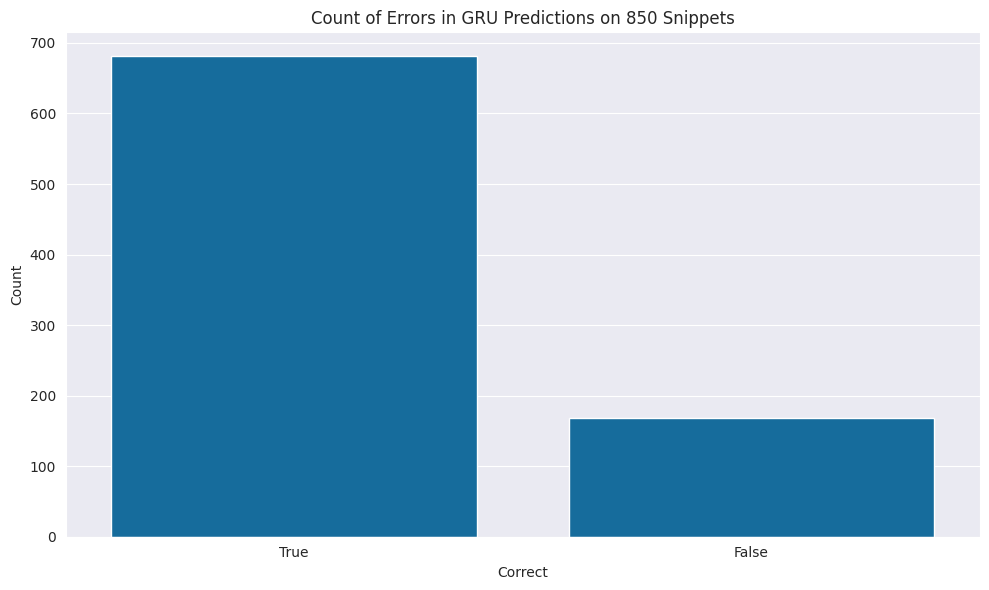

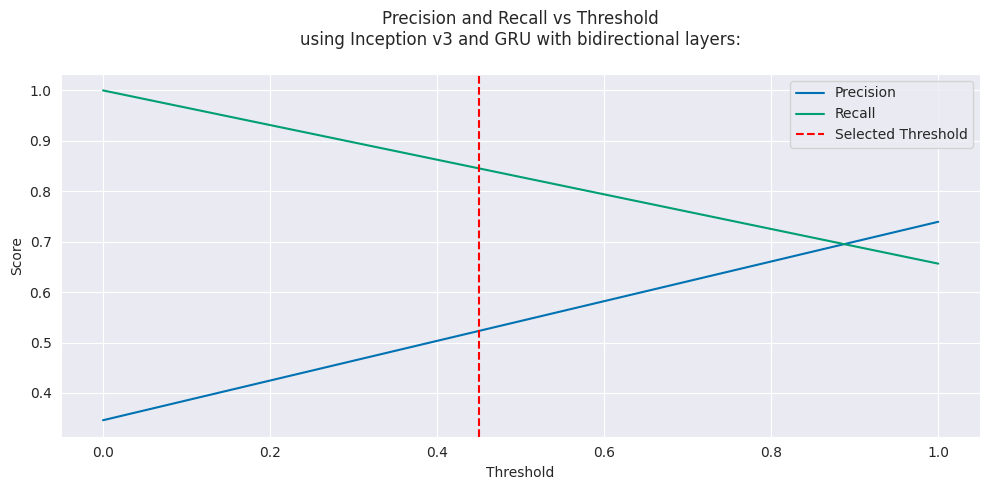

Classification Report on 850 sniffing snippets
using Inception v3 and GRU with bidirectional layers:

              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85       556
    Positive       0.74      0.66      0.70       294

    accuracy                           0.80       850
   macro avg       0.78      0.77      0.77       850
weighted avg       0.80      0.80      0.80       850



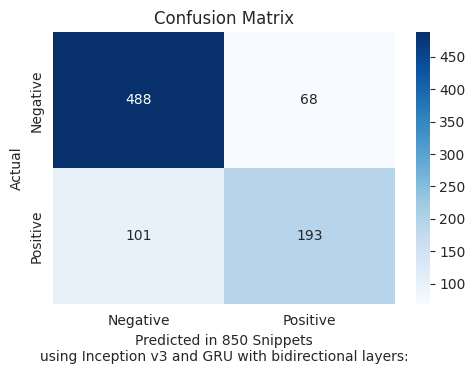

In [ ]:
count_nr_snippets = len(all_true_pred)

# count plot of the errors
plt.figure(figsize=(10, 6))
sns.countplot(data=all_true_pred, x='correctPrediction', order=[True, False])
plt.title(f'Count of Errors in GRU Predictions on {count_nr_snippets} Snippets')
plt.xlabel('Correct')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
all_true_pred['correctPrediction'].value_counts()

# Calculate accuracy
accuracy = accuracy_score(all_true_pred['label'], all_true_pred['predicted_class'])
print(f"\nAccuracy: {accuracy * 100:.2f}%")
# Calculate precision, recall, and F1-score

from sklearn.metrics import classification_report
report = classification_report(all_true_pred['label'], all_true_pred['predicted_class'], target_names=['negative', 'positive'])
print(f"Classification Report:\nusing Inception v3 and GRU with bidirectional layers:\n{report}")
print("")


from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
THRESHOLD = POSITIVE_THRESHOLD

y_truth = all_true_pred['label'].map({'negative': 0, 'positive': 1}).values
y_pred = all_true_pred['predicted_class'].map({'negative': 0, 'positive': 1}).values

# Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_truth, y_pred)

# Plot PR curve
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(THRESHOLD, color='red', linestyle='--', label='Selected Threshold')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(f"Precision and Recall vs Threshold\nusing Inception v3 and GRU with bidirectional layers:\n")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Classification report

print(f"Classification Report on {count_nr_snippets} sniffing snippets\nusing Inception v3 and GRU with bidirectional layers:\n")
print(classification_report(y_truth, y_pred, target_names=["Negative", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_truth, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel(f"Predicted in {count_nr_snippets} Snippets\nusing Inception v3 and GRU with bidirectional layers:\n")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

##### NEXT STEP = SAVE MODEL AND WEIGHTS
##### ONLY WHEN ACCURACY AND RECALL IS SATISFACTORY !!!!

# # check 

# destination_folder = "models/gru/"
# os.makedirs(destination_folder, exist_ok=True)

# # # Save the model
# sequence_model.save("models/gru/my_video_classifier_model.h5")

# # Save the label processor
# with open("models/gru/label_processor.pkl", "wb") as f:
#     pickle.dump(label_processor, f)

# # Save the feature extractor
# feature_extractor.save("models/gru/my_feature_extractor_model.h5")

# # Save the sequence model
# sequence_model.save("models/gru/my_sequence_model.h5")
# # Save the training and testing data
# with open("models/gru/train_data.pkl", "wb") as f:
#     pickle.dump(train_data, f)

# <a id='toc28_'></a>[ROC & AUC](#toc0_)

In [ ]:
from sklearn.metrics import confusion_matrix,roc_curve, auc

In [52]:
# Confusion matrix & classification report
cm = confusion_matrix(y_truth, y_pred)

cr = classification_report(y_truth, y_pred, target_names=['negative','positive'])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)

Confusion Matrix:
 [[488  68]
 [101 193]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.88      0.85       556
    positive       0.74      0.66      0.70       294

    accuracy                           0.80       850
   macro avg       0.78      0.77      0.77       850
weighted avg       0.80      0.80      0.80       850



Validation ROC AUC = 0.7671


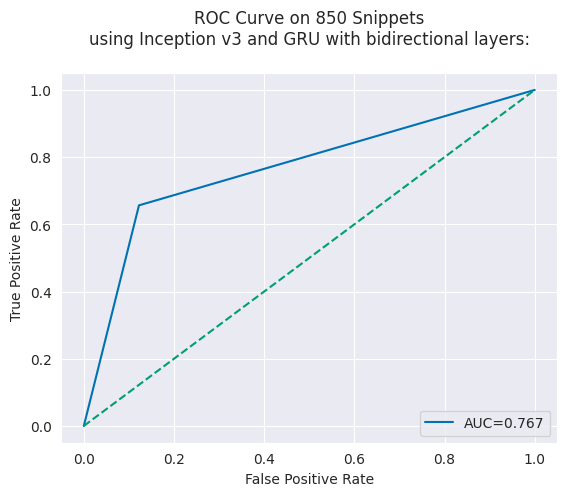

'\nAUC = 1.0 would be perfect.\nAUC = 0.5 is as bad as random guessing.\nAUC = 0.767 means your model is pretty good—it’s much better than guessing, but not perfect.\n\nSummary:\nThe closer the blue line is to the top left corner, the better. \nThe model (AUC = 0.767) is doing a decent job at making correct predictions\n'

In [ ]:
# ROC curve & AUC
fpr, tpr, _ = roc_curve(y_truth, y_pred)
roc_auc    = auc(fpr, tpr)
print(f"Validation ROC AUC = {roc_auc:.4f}")

# Plot it
plt.figure()
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve on {count_nr_snippets} Snippets\nusing Inception v3 and GRU with bidirectional layers:\n")
plt.legend(loc='lower right')
plt.show()
'''
AUC = 1.0 would be perfect.
AUC = 0.5 is as bad as random guessing.
AUC = 0.767 means your model is pretty good—it’s much better than guessing, but not perfect.

Summary:
The closer the blue line is to the top left corner, the better. 
The model (AUC = 0.767) is doing a decent job at making correct predictions
'''


# <a id='toc29_'></a>[NEXT STEPS?](#toc0_)

We made use of a model of the keras.applications and models. 
We followed a tutorial made for human behavior. 

We made use of transfer learning for extracting meaningful features from video frames. 
WE fined tuned the pre-trained network to notice how that affects the end results.
For speed-accuracy trade-offs, we tried out other models present inside keras.applications. Eg LSTM, LSTM-CNN. 
We tried different combinations of MAX_SEQ_LENGTH and observes how that affects the performance.

Following we could try a pre-trained action recognition model from DeepMind.
Rolling-averaging can be useful technique for video classification and it can be combined with a standard image classification model to infer on videos. We could try rolling-averaging with an image classifier.
When there are variations in between the frames of a video not all the frames might be equally important to decide its category. In those situations, putting a self-attention layer in the sequence model will likely yield better results.
Following we could implement Transformers-based models for processing videos.

Other approaches could be explored more too. Lstm in combination of CNN and 3D CNN models.
Other approaches for the preparation of the dataset. 
The use of an added optimizer in the training on level of the layes of the model. 
Research on video classification of animal behavior. 
...
